In [4]:
import torch
import pandas as pd
import numpy as np
# 新数据
# 读取所有数据
paths = [
    '../data/processed_data_900_1.csv'#, '../data/processed_data_900_2.csv', '../data/processed_data_900_3.csv',
    # '../data/processed_data_1050_1.csv', '../data/processed_data_1050_2.csv', '../data/processed_data_1050_3.csv',
    # '../data/processed_data_1200_1.csv', '../data/processed_data_1200_2.csv', '../data/processed_data_1200_3.csv',
    # '../data/processed_data_1350_1.csv', '../data/processed_data_1350_2.csv', '../data/processed_data_1350_3.csv',
    # '../data/processed_data_1500_1.csv', '../data/processed_data_1500_2.csv', '../data/processed_data_1500_3.csv',
    # '../data/processed_data_1650_1.csv', '../data/processed_data_1650_2.csv', '../data/processed_data_1650_3.csv',
]

# 读取并拼接数据
all_data = pd.concat([pd.read_csv(path) for path in paths], ignore_index=True)
all_data = np.array(all_data)
all_data.shape

(446, 1)

In [73]:
# 
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from copy import deepcopy
import pandas as pd
# 设定随机种子以保证结果可复现
torch.manual_seed(0)
np.random.seed(0)

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
all_data

array([['(Mo3O9,91);(Mo3O9S2,13);(MoO2,5);(MoOS,11);(MoO2,13);(MoO,40);(MoOS2,3);(MoO,1);(MoOS2,14);(MoS,2);(MoOS2,1);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,4);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,12);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,15);(MoS,1);(MoOS2,8);(MoS,1);(MoOS2,4);(MoS,2);(MoOS2,6);(MoS,1);(MoOS2,2);(MoS,1);(MoOS2,13);(MoS,3);(MoO2S,1);(MoOS,76);(MoOS3,2);(MoOS,7);(MoOS3,7);(MoOS,49);(MoOS3,19);(MoS2,101);(Mo2S7,3);(MoS3,1);(Mo2S7,57);(Mo2S5,1);(Mo2S7,118);(MoO,25);(MoOS,16);(MoS,9);(MoS2,52);(MoO,6);(MoOS2,4);(MoS,1);(MoOS2,9);(MoS,156);(MoS3,9);(MoS,1);(MoS3,57);(MoS,1);(MoS3,68);(MoOS4,1);(MoS3,52);(MoS5,27);(MoS3,187);(MoOS4,1);(MoS3,84);(MoS5,269);(MoOS6,3);(MoS5,1);(MoOS6,4);(MoS3,1);(MoS5,1);(MoOS6,10);(MoS5,1);(MoOS6,1);(MoS5,1);(MoOS6,2);(MoS5,1);(MoOS6,3);(MoS5,158);(MoS6,4);(MoS4,1);(MoS6,759);(MoOS7,1);(MoS6,743);(MoS8,38);(MoS6,539);(MoOS7,1);(MoS6,2);(MoOS7,15);(MoS6,2);(MoOS7,6);(MoS6,1);(MoOS7,101);(MoS6,3);(MoOS7,123);(MoS6,321);(MoS8,208);(MoS10,1);(M

In [ ]:
import re

raw_data = "(Mo3O9,91);(Mo3O9S2,13);(Mo2O4,5);(MoO,2);(MoO3,9)"
parsed_data = re.findall(r"\(([^,]+),(\d+)\)", raw_data)
data = [(formula, int(count)) for formula, count in parsed_data]
print(data)

In [56]:
# 处理数据的函数
def process_data(data):
    pro_data = []
    for record in data:
        # print(record)
        # break
        # 每条记录是一个字符串，将其按分号分割
        elements = record[0].split(';')
        processed_data = []
        for element in elements:
            # print(element)
            # 去除括号并按逗号分割成元素和数字
            mol, count = element.strip('()').split(',')
            processed_data.append((mol, int(count)))
        pro_data.append(np.array(processed_data))
    return pro_data

# 调用函数处理数据
processed = process_data(all_data)
processed = np.array(processed)
print(processed.shape)

(446,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_15256\1924894040.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  processed = np.array(processed)


In [57]:
processed[1].shape

(621, 2)

AttributeError: 'numpy.str_' object has no attribute 'type'

In [45]:
import numpy as np
# 编码，转换成向量
def incode(molecule):
    vec = np.zeros(3)
    length = len(molecule)
    Mo = molecule.find('Mo')
    O = molecule.find('O')
    S = molecule.find('S')
    # print(Mo, O, S)
    moi = oi = si = 0
    moi = 1
    if O==-1 and S==-1 and length>2:
        moi = molecule[Mo+2:]
    elif O != -1:
        if O > Mo + 2:
            moi = int(molecule[Mo+2:O])
        else:
            moi = 1
        if S == O + 1 or O+1==length:
            oi = 1
        elif S==-1:
            oi = int(molecule[O+1:])
        else:
            oi = int(molecule[O+1:S])
    elif S != -1:
        if S > Mo + 2:
            moi = int(molecule[Mo+2:S])
        else:
            moi = 1
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    if S!=-1:
        if S+1==length:
            si = 1
        else:
            si = int(molecule[S+1:])
    vec = np.array([moi, oi, si])
    return vec
incode('MoOS13')

array([ 1,  1, 13])

In [68]:
# 使用列表推导式遍历二维数组并调用函数进行编码，将返回值存储在新的二维数组中
# all_data = [[incode(value) for value in row] for row in cy_data]
# all_data = np.array(all_data)
# all_data.shape
cy_data = processed#.iloc[:, :2500]#.iloc[:, ::10]  # 对数据进行每隔10列重新采样
cy_data = np.array(cy_data)
cy_data = [[np.append(incode(value[0]), int(value[1])) for value in row] for row in cy_data]
# cy_data = np.concatenate(cy_data)
cy_data = np.array(cy_data)
cy_data.shape #(1726, 3000, 3)

C:\Users\dfgje\AppData\Local\Temp\ipykernel_15256\2121739356.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cy_data = np.array(cy_data)


(446,)

In [72]:
# 构建数据集
def create_dataset(data, sequence_length):
    # print('len(data) - sequence_length',len(data) - sequence_length)
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        # 将每个张量移动到 CPU 上并转换为 NumPy 数组
    return sequences#[tensor.cpu().numpy() for tensor in sequences] #np.array(sequences)

In [ ]:
# 构建数据集
def create_dataset(data, sequence_length):
    # print('len(data) - sequence_length',len(data) - sequence_length)
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        # 将每个张量移动到 CPU 上并转换为 NumPy 数组
    return sequences#[tensor.cpu().numpy() for tensor in sequences] #np.array(sequences)
# sequences = torch.tensor(sequences)
# tensor_sequences = [torch.tensor(seq) for seq in sequences]
# print('tensor_sequences.shape', sequences.shape)
sequence_length = 10
sequences = create_dataset(cy_data, sequence_length)
sequences = [tensor for tensor in tqdm(sequences)]
sequences = np.array(sequences)
# sequences = torch.stack(sequences)
print('sequences.shape', sequences.shape)# sequences.shape (2900, 100, 1726, 3)
X = sequences[:-1]
y = sequences[1:, -1]
print('X.shape', X.shape)# X.shape (2899, 100, 1726, 3)
print('y.shape', y.shape)# y.shape (2899, 1726, 3)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, shuffle=True, random_state=42)
# print('X_train.shape', X_train.shape, 'y_train', y_train.shape)
# print('X_test.shape', X_test.shape)

# X = np.transpose(X, (2, 0, 1, 3))
# y = np.transpose(y, (1, 0, 2))
# print('X.shape', X.shape) # X.shape (1726, 2899, 100, 3)
# print('y.shape', y.shape) # y.shape (1726, 2899, 3)

# # 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
# print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
# print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
# print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

100%|██████████| 436/436 [00:00<?, ?it/s]

sequences.shape (436, 10)
X.shape (435, 10)
y.shape (435,)


In [95]:
import numpy as np
from tqdm import tqdm

# 构建数据集
def create_dataset(data, sequence_length):
    """
    将输入数据分割为长度为 sequence_length 的序列。
    """
    sequences = []
    for i in range(len(data) - sequence_length):
        # 构建序列
        sequences.append(data[i:i + sequence_length])
    return sequences

# 参数
sequence_length = 10

# 假设 cy_data 是 list，转换为合适的格式
# 如果 cy_data 是嵌套 list，则可以直接用它；否则，先检查数据格式
sequences = []
X = []
y = []
for row in cy_data:
    sequence = create_dataset(row, sequence_length)
    sequence = np.array(sequence)
    sequences.append(sequence)
    X.append(sequence[:-1])  # 除去最后一个序列
    y.append(sequence[1:, -1])  # 每个序列的最后一个时间步作为输出

sequences = np.array(sequences)
X = np.array(X)
y = np.array(y)
# 检查生成的序列形状
print('sequences.shape', sequences.shape)

# 构建输入 X 和输出 y

print('X.shape', X.shape)  # 输入的形状
print('y.shape', y.shape)  # 输出的形状


sequences.shape (446,)
X.shape (446,)
y.shape (446,)


C:\Users\dfgje\AppData\Local\Temp\ipykernel_15256\1166615506.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sequences = np.array(sequences)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_15256\1166615506.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
C:\Users\dfgje\AppData\Local\Temp\ipykernel_15256\1166615506.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

In [106]:
# 将数据划分为训练集和测试集，可以指定测试集的大小和随机种子
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (267,)
X_test.shape (179,)
y_train.shape (267,)
y_test.shape (179,)


In [107]:
X_train = np.concatenate(X_train)
X_train = X_train.reshape(-1, 10, 4)
y_train = np.concatenate(y_train)
X_test = np.concatenate(X_test)
X_test = X_test.reshape(-1, 10, 4)
y_test = np.concatenate(y_test)
print('X_train.shape', X_train.shape)# X_train.shape (1035, 2899, 100, 3)
print('X_test.shape', X_test.shape)# X_test.shape (691, 2899, 100, 3)
print('y_train.shape', y_train.shape)# y_train.shape (1035, 2899, 3)
print('y_test.shape', y_test.shape)# y_test.shape (691, 2899, 3)

X_train.shape (130657, 10, 4)
X_test.shape (102104, 10, 4)
y_train.shape (130657, 4)
y_test.shape (102104, 4)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化scaler
scaler = MinMaxScaler()

# Reshape the data to 2D for fitting the scaler
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (130657*10, 4)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back to original dimensions
X_train_normalized = X_train_scaled.reshape(X_train.shape)  # (130657, 10, 4)
X_test_normalized = X_test_scaled.reshape(X_test.shape)    # (102104, 10, 4)

y_train_reshaped = y_train.reshape(-1, y_train.shape[-1])  # (130657*10, 4)
y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])    # (102104*10, 4)

# Fit the scaler on training data and transform both train and test sets
y_train_scaled = scaler.fit_transform(y_train_reshaped)
y_test_scaled = scaler.transform(y_test_reshaped)

# Reshape back to original dimensions
y_train_normalized = y_train_scaled.reshape(y_train.shape)  # (130657, 10, 4)
y_test_normalized = y_test_scaled.reshape(y_test.shape)    # (102104, 10, 4)

X_train_normalized.shape, y_train_normalized.shape, X_test_normalized.shape, y_test_normalized.shape

((130657, 10, 4), (130657, 4), (102104, 10, 4), (102104, 4))

In [117]:
# train_data = TensorDataset(X_train, y_train)
# test_data = TensorDataset(X_test, y_test)
train_data = TensorDataset(torch.tensor(X_train_normalized), torch.tensor(y_train_normalized))
# train_data = TensorDataset(torch.tensor(X_train_new), torch.tensor(y_train_new))
test_data = TensorDataset(torch.tensor(X_test_normalized), torch.tensor(y_test_normalized))

d:\Software\anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train epoch 0: 100%|██████████| 511/511 [00:02<00:00, 210.24batch/s]


Epoch 1/100, Train Loss: 0.009104747621346184, Validation Loss: 0.004193975350044593 Current learning rate: 0.0001


train epoch 1: 100%|██████████| 511/511 [00:02<00:00, 220.43batch/s]


Epoch 2/100, Train Loss: 0.004367378527807061, Validation Loss: 0.0038546278298409995 Current learning rate: 0.0001


train epoch 2: 100%|██████████| 511/511 [00:02<00:00, 228.50batch/s]


Epoch 3/100, Train Loss: 0.003662051258808268, Validation Loss: 0.0029165513908611914 Current learning rate: 0.0001


train epoch 3: 100%|██████████| 511/511 [00:02<00:00, 221.15batch/s]


Epoch 4/100, Train Loss: 0.0027541515005956568, Validation Loss: 0.0026143593748653294 Current learning rate: 0.0001


train epoch 4: 100%|██████████| 511/511 [00:02<00:00, 232.05batch/s]


Epoch 5/100, Train Loss: 0.0025089397901052212, Validation Loss: 0.0025706832139008214 Current learning rate: 0.0001


train epoch 5: 100%|██████████| 511/511 [00:02<00:00, 228.70batch/s]


Epoch 6/100, Train Loss: 0.0024208806447389513, Validation Loss: 0.002427324984119948 Current learning rate: 0.0001


train epoch 6: 100%|██████████| 511/511 [00:02<00:00, 231.36batch/s]


Epoch 7/100, Train Loss: 0.00237423015747346, Validation Loss: 0.0022146135321637395 Current learning rate: 0.0001


train epoch 7: 100%|██████████| 511/511 [00:02<00:00, 232.50batch/s]


Epoch 8/100, Train Loss: 0.002335288944843712, Validation Loss: 0.002008384115561285 Current learning rate: 0.0001


train epoch 8: 100%|██████████| 511/511 [00:02<00:00, 228.83batch/s]


Epoch 9/100, Train Loss: 0.0022993838239585116, Validation Loss: 0.0019763238649050307 Current learning rate: 0.0001


train epoch 9: 100%|██████████| 511/511 [00:02<00:00, 230.09batch/s]


Epoch 10/100, Train Loss: 0.0022608829263976817, Validation Loss: 0.002345802230185089 Current learning rate: 0.0001
EarlyStopping counter: 1 out of 10


train epoch 10: 100%|██████████| 511/511 [00:02<00:00, 221.58batch/s]


Epoch 11/100, Train Loss: 0.0022358083490367957, Validation Loss: 0.0019644139303048526 Current learning rate: 0.0001


train epoch 11: 100%|██████████| 511/511 [00:02<00:00, 231.45batch/s]


Epoch 12/100, Train Loss: 0.002167308222937148, Validation Loss: 0.0018972024467221128 Current learning rate: 0.0001


train epoch 12: 100%|██████████| 511/511 [00:02<00:00, 221.05batch/s]


Epoch 13/100, Train Loss: 0.002120290850620642, Validation Loss: 0.0018265966252983433 Current learning rate: 0.0001


train epoch 13: 100%|██████████| 511/511 [00:02<00:00, 230.31batch/s]


Epoch 14/100, Train Loss: 0.0020843369524417683, Validation Loss: 0.0018105968813238874 Current learning rate: 0.0001


train epoch 14: 100%|██████████| 511/511 [00:02<00:00, 219.99batch/s]


Epoch 15/100, Train Loss: 0.002054071550051556, Validation Loss: 0.0017890221239295193 Current learning rate: 0.0001


train epoch 15: 100%|██████████| 511/511 [00:02<00:00, 231.37batch/s]


Epoch 16/100, Train Loss: 0.002034642562299667, Validation Loss: 0.001765937078890057 Current learning rate: 0.0001


train epoch 16: 100%|██████████| 511/511 [00:02<00:00, 230.20batch/s]


Epoch 17/100, Train Loss: 0.0020156980428826807, Validation Loss: 0.0017283638645268983 Current learning rate: 0.0001


train epoch 17: 100%|██████████| 511/511 [00:02<00:00, 232.00batch/s]


Epoch 18/100, Train Loss: 0.0019977076224787496, Validation Loss: 0.0017156889589934057 Current learning rate: 0.0001


train epoch 18: 100%|██████████| 511/511 [00:02<00:00, 228.95batch/s]


Epoch 19/100, Train Loss: 0.001986750504630185, Validation Loss: 0.0017761726242435845 Current learning rate: 0.0001
EarlyStopping counter: 2 out of 10


train epoch 19: 100%|██████████| 511/511 [00:02<00:00, 206.88batch/s]


Epoch 20/100, Train Loss: 0.0019775531518835994, Validation Loss: 0.0017641558958546323 Current learning rate: 0.0001
EarlyStopping counter: 3 out of 10


train epoch 20: 100%|██████████| 511/511 [00:02<00:00, 215.54batch/s]


Epoch 21/100, Train Loss: 0.0019747354899112314, Validation Loss: 0.0017478096340705622 Current learning rate: 0.0001
EarlyStopping counter: 4 out of 10


train epoch 21: 100%|██████████| 511/511 [00:04<00:00, 115.32batch/s]


Epoch 22/100, Train Loss: 0.0019787392445916032, Validation Loss: 0.0016910523579160934 Current learning rate: 0.0001


train epoch 22: 100%|██████████| 511/511 [00:04<00:00, 118.11batch/s]


Epoch 23/100, Train Loss: 0.0019580352550692907, Validation Loss: 0.0016475364635672968 Current learning rate: 0.0001


train epoch 23: 100%|██████████| 511/511 [00:04<00:00, 114.88batch/s]


Epoch 24/100, Train Loss: 0.0019672414627986794, Validation Loss: 0.0016272239809542388 Current learning rate: 0.0001


train epoch 24: 100%|██████████| 511/511 [00:04<00:00, 118.44batch/s]


Epoch 25/100, Train Loss: 0.001937607149868623, Validation Loss: 0.0016144919425979357 Current learning rate: 0.0001


train epoch 25: 100%|██████████| 511/511 [00:02<00:00, 227.83batch/s]


Epoch 26/100, Train Loss: 0.0019240715185648131, Validation Loss: 0.0016139568756432226 Current learning rate: 0.0001
EarlyStopping counter: 5 out of 10


train epoch 26: 100%|██████████| 511/511 [00:02<00:00, 234.04batch/s]


Epoch 27/100, Train Loss: 0.001907636017304865, Validation Loss: 0.0015925457750721702 Current learning rate: 0.0001


train epoch 27: 100%|██████████| 511/511 [00:02<00:00, 230.19batch/s]


Epoch 28/100, Train Loss: 0.001887760732913608, Validation Loss: 0.0015815625296406659 Current learning rate: 0.0001


train epoch 28: 100%|██████████| 511/511 [00:02<00:00, 232.73batch/s]


Epoch 29/100, Train Loss: 0.0018759108237549594, Validation Loss: 0.001582080290115886 Current learning rate: 0.0001
EarlyStopping counter: 6 out of 10


train epoch 29: 100%|██████████| 511/511 [00:02<00:00, 228.33batch/s]


Epoch 30/100, Train Loss: 0.0018608866314929519, Validation Loss: 0.0015876169698795753 Current learning rate: 0.0001
EarlyStopping counter: 7 out of 10


train epoch 30: 100%|██████████| 511/511 [00:02<00:00, 214.45batch/s]


Epoch 31/100, Train Loss: 0.0018537493816525867, Validation Loss: 0.0015848929057087993 Current learning rate: 0.0001
EarlyStopping counter: 8 out of 10


train epoch 31: 100%|██████████| 511/511 [00:02<00:00, 226.98batch/s]


Epoch 32/100, Train Loss: 0.0018421887303531669, Validation Loss: 0.0015791288090606901 Current learning rate: 0.0001


train epoch 32: 100%|██████████| 511/511 [00:02<00:00, 223.62batch/s]


Epoch 33/100, Train Loss: 0.0018292685409931173, Validation Loss: 0.0015957127705355436 Current learning rate: 0.0001
EarlyStopping counter: 9 out of 10


train epoch 33: 100%|██████████| 511/511 [00:02<00:00, 231.87batch/s]


Epoch 34/100, Train Loss: 0.001828247159861569, Validation Loss: 0.0015949455747912744 Current learning rate: 0.0001
EarlyStopping counter: 10 out of 10
Early stopping


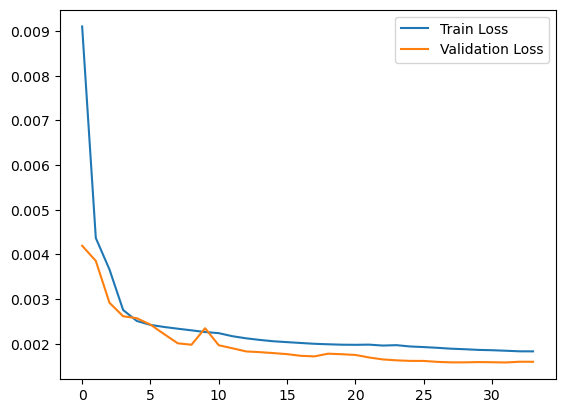

Epoch 34/100, Train Loss: 0.001828247159861569, Validation Loss: 0.0015949455747912744
Test RMSE: 0.03974404
CPU times: total: 2min 8s
Wall time: 1min 59s


In [135]:
%%time
from torch.nn.parallel import DataParallel
import torch.nn.functional as F

hidden_size = 256
num_layers = 2
batch_size = 256
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)
 
# LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        # Decode the hidden state of the last time step
        out = self.dropout(out[:, -1, :])  # Apply dropout before the fully connected layer
        out = self.fc(out)
        return out
    
# class LSTM(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTM, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes)
#         self.softmax = nn.Softmax(dim=1)  # Use softmax for multi-class classification

#     def forward(self, x):
#         # Initialize hidden state with zeros
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Initialize cell state
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
#         # Forward propagate LSTM
#         out, _ = self.lstm(x, (h0, c0))
#         # Decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         # Apply softmax to the output layer
#         out = self.softmax(out)
#         return out
    
# LSTM_SelfAttention model
class SelfAttention(nn.Module):
    def __init__(self, hidden_size):
        super(SelfAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Parameter(torch.rand(hidden_size, 1))

    def forward(self, lstm_output):
        # lstm_output的形状是(batch_size, seq_len, hidden_size)
        attention_scores = torch.matmul(lstm_output, self.attention_weights)
        # attention_scores的形状是(batch_size, seq_len, 1)
        attention_scores = F.softmax(attention_scores, dim=1)
        # 使用attention_scores对lstm_output进行加权求和
        weighted_output = lstm_output * attention_scores
        output = torch.sum(weighted_output, dim=1)
        # output的形状是(batch_size, hidden_size)
        return output
    
# LSTM_SelfAttention model
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = SelfAttention(hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 使用自注意力机制处理LSTM的输出
        attn_out = self.attention(lstm_out)
        # 应用 Dropout
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# BiLSTM-MAIN model
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        
        self.attention_heads = nn.Parameter(torch.Tensor(num_heads, self.head_dim, 1))
        nn.init.xavier_uniform_(self.attention_heads)
        
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, lstm_output):
        batch_size, seq_len, hidden_size = lstm_output.size(0), lstm_output.size(1), lstm_output.size(2)
        # Reshape lstm_output to (batch_size, seq_len, num_heads, head_dim)
        lstm_output = lstm_output.view(batch_size, seq_len, self.num_heads, self.head_dim)
        # Transpose for matrix multiplication: (batch_size, num_heads, seq_len, head_dim)
        lstm_output = lstm_output.transpose(1, 2)
        # Compute attention scores
        attention_scores = torch.matmul(lstm_output, self.attention_heads)
        # Apply softmax to get the weights on the values
        attention_scores = F.softmax(attention_scores, dim=-2)
        # Apply attention weights to lstm_output
        weighted_output = attention_scores * lstm_output
        # Sum weighted output over seq_len dimension
        weighted_output = weighted_output.sum(dim=-2)
        # Reshape weighted_output to (batch_size, hidden_size)
        weighted_output = weighted_output.reshape(batch_size, -1)
        # Pass through the fully connected layer
        output = self.fc(weighted_output)
        return output

# BiLSTM-MAIN model
class LSTMWithMulAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, num_heads):
        super(LSTMWithMulAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.attention = MultiHeadSelfAttention(hidden_size*2, num_heads)  # 注意hidden_size*2因为BiLSTM
        self.layer_norm = nn.LayerNorm(hidden_size*2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        # 添加残差连接的线性层
        self.residual_fc = nn.Linear(hidden_size*2, hidden_size*2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)  # 乘以2因为BiLSTM
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        # 添加残差连接
        residual_output = lstm_out + self.residual_fc(lstm_out)
        lstm_out = self.layer_norm(residual_output)
        attn_out = self.attention(lstm_out)
        drop_out = self.dropout(attn_out)
        out = self.fc(drop_out)
        return out

# print('X_train.shape[-1]:',X_train.shape[-1])

input_size = 4
num_classes= 4
# model = LSTM(input_size, hidden_size, num_layers, num_classes, dropout_prob=0)
#model = LSTMWithAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate = 0.2)
model = LSTMWithMulAttention(input_size, hidden_size, num_layers, num_classes, dropout_rate=0.1, num_heads=8)
# print('num_classes:', num_classes)
model = model.to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss() #nn.CrossEntropyLoss() #nn.MSELoss() #custom_loss 
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min',factor=0.5, patience=3, min_lr=1e-6, verbose=True)

# 训练模型
num_epochs = 100
best_loss = np.inf
early_stopping_patience = 10
early_stopping_counter = 0
loss_values = []

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for i, (x_batch, y_batch) in enumerate(tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch")): #tqdm(train_loader, desc=f"train epoch {epoch}" ,unit="batch"))
        # one_batch_bar.set_description(f'[ epoch: {ep+1} ]')
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
#         print('x_batch:', x_batch.shape)
#         print('y_batch:', y_batch.shape)
        
        optimizer.zero_grad()
        # print('x_batch shape:',x_batch.shape[0])
        # print(x_batch.shape)
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        
        outputs = model(x_batch)
        # print('outputs:', outputs.shape)
        loss = criterion(outputs, y_batch) #, x_batch
        loss.backward()
        optimizer.step()
        # break
        train_losses.append(loss.item())
        # 更新进度条后缀信息，显示当前损失值
        # tqdm.set_postfix({'loss': loss / (100 * (epoch+1))}, refresh=True)
    
    val_losses = []
    model.eval()
    with torch.no_grad():
        # for i, (x_batch, y_batch) in enumerate(test_loader):
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch = x_batch.to(device).float()
            y_batch = y_batch.to(device).float()
            
            x_batch = x_batch.view(-1, sequence_length, input_size)
            y_batch = y_batch.view(-1, input_size)
            # y_batch = y_batch.squeeze().long()
            
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch) #, x_batch
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    scheduler.step(train_loss)
    loss_values.append([train_loss, val_loss])

    # if epoch%10==0 :
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}', "Current learning rate:", scheduler.get_last_lr()[0])
    # 在每个 epoch 结束时获取最后设置的学习率并打印

    if val_loss - best_loss < -0.000001:
        # early_stopping_counter = 0
        best_loss = val_loss
        best_model = deepcopy(model.state_dict())
    else:
        early_stopping_counter += 1
        print(f'EarlyStopping counter: {early_stopping_counter} out of {early_stopping_patience}')
        if early_stopping_counter >= early_stopping_patience:
            model.load_state_dict(best_model)
            print('Early stopping')
            break

# 保存最好的模型
torch.save(best_model, '../model/lstm_t1.pth')#########################################################

# 画出loss变化曲线
loss_values = np.array(loss_values)
plt.plot(loss_values[:, 0], label='Train Loss')
plt.plot(loss_values[:, 1], label='Validation Loss')
plt.legend()
plt.show()

# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 
print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
print('Test RMSE:', np.sqrt(mean_squared_error(targets, predictions)))

In [127]:
# 评估预测结果
model.eval()
predictions = []
targets = []
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()
        x_batch = x_batch.view(-1, sequence_length, input_size)
        y_batch = y_batch.view(-1, input_size)
        outputs = model(x_batch)
        predictions.append(outputs.cpu().numpy())
        targets.append(y_batch.cpu().numpy()) 

predictions = np.concatenate(predictions)
targets = np.concatenate(targets) 

In [136]:
# 数据转回原始尺度
predictions = scaler.inverse_transform(predictions)
targets = scaler.inverse_transform(targets)


In [141]:
predictions[100], targets[100], predictions.shape, targets.shape

(array([1.0047483e+00, 4.1949246e-03, 5.0357013e+00, 2.4206024e+01],
       dtype=float32),
 array([1.        , 0.        , 5.        , 0.99999994], dtype=float32),
 (102104, 4),
 (102104, 4))

In [145]:
y_test[0]

array([1, 0, 1, 1])

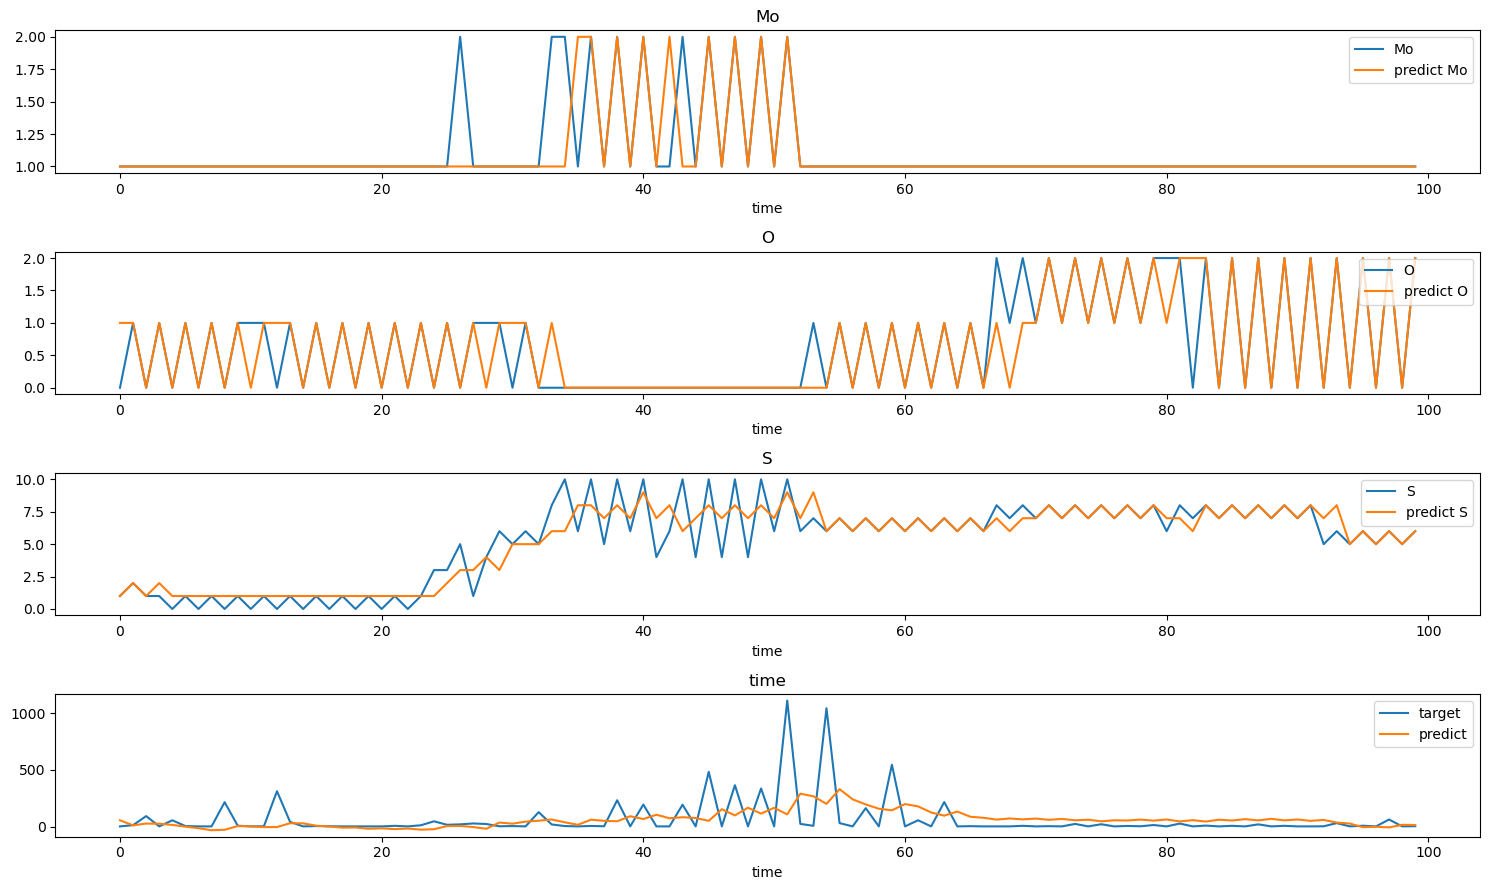

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
p_round = predictions.round()
t_round = y_test #targets.round()
p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('state transition')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')

In [140]:
t_round.shape

NameError: name 't_round' is not defined

In [151]:
dd = np.array(cy_data[0])
dd.shape

(464, 4)

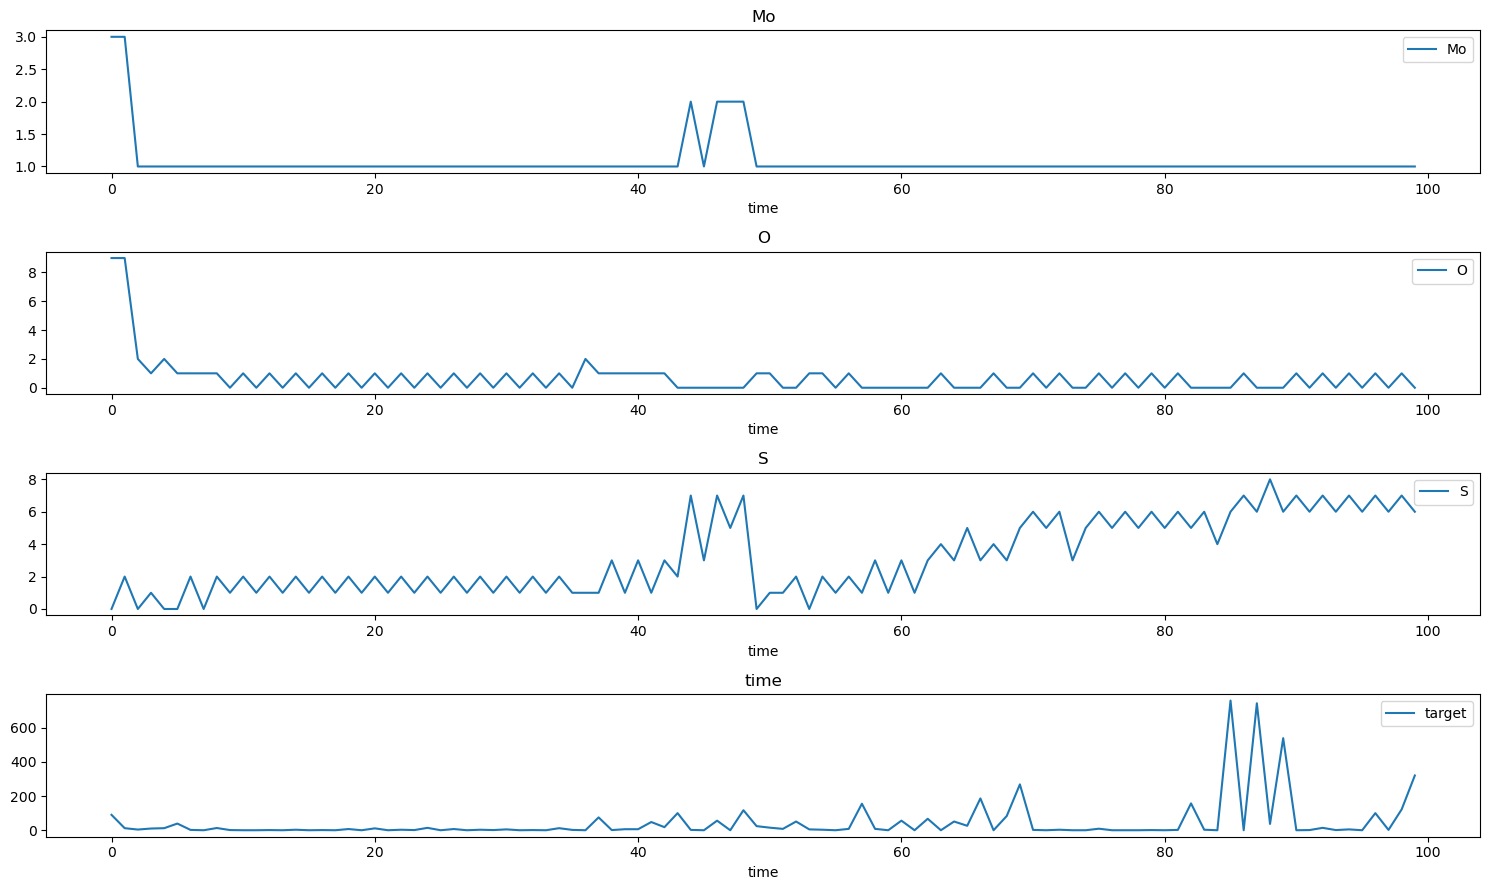

In [152]:
# 可视化cy_data
import matplotlib.pyplot as plt
import numpy as np

# 生成示例数据
# x = np.linspace(0, 10, 100)
# y1 = np.sin(x)
# y2 = np.cos(x)
# y3 = np.tan(x)
num = 8000
start = 0
end = 100
# p_round = predictions.round()
t_round = dd #targets.round()
# p1 = p_round[start:end, :]
t1 = t_round[start:end, :]
# 创建一个包含三个子图的画布
fig, axs = plt.subplots(4, 1, figsize=(15, 9))

# 在第一个子图中绘制 y1
axs[0].plot(t1[:, 0], label='Mo')
# axs[0].plot(p1[:, 0], label='predict Mo')
#
axs[0].set_title('Mo')
axs[0].legend(loc='upper right')

# 在第二个子图中绘制 y2
axs[1].plot(t1[:, 1], label='O')
# axs[1].plot(p1[:, 1], label='predict O')
# axs[1].plot(p1[:, 1], color='blue', label='predict O')
# axs[1].plot(t1[:, 1], color='red', label='O')
axs[1].set_title('O')
axs[1].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[2].plot(t1[:, 2], label='S')
# axs[2].plot(p1[:, 2], label='predict S')
axs[2].set_title('S')
axs[2].legend(loc='upper right')
# 在第三个子图中绘制 y3
axs[3].plot(t1[:, 3], label='target')
# axs[3].plot(p1[:, 3], label='predict')
axs[3].set_title('time')
axs[3].legend(loc='upper right')
# 设置统一的横坐标标签
for ax in axs:
    # plt.xlim(1100, 1200)
    ax.set_xlabel('time')
# axs[0].set_xlim(1100, 1200)
# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()
# plt.savefig('result.png')